# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sig =  1 / (1 + np.exp(-X@weights))
        return sig
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""       
        loss = np.mean(np.log(1+np.exp(-np.dot(x, weights)*y))) + 1/(2*self.C)*np.amin((np.linalg.norm(weights))**2)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        losses = []
        for i in range(self.max_iter):
            loss = self.get_loss(X_ext,self.weights_,y)
            losses.append(loss)
            delta = X_ext.T@(y*(1.-1/(1+np.exp(np.dot(-X_ext,self.weights_)*y))))/len(y)-(1/self.C)*self.weights_
            self.weights_ -= self.eta * delta * (-1)
            if np.linalg.norm(delta)< self.tol:
                break
        return losses
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        prediction = np.where(self.predict_proba(X) >= 0.5, 1, -1)
        return prediction

In [5]:
from sklearn import datasets
from sklearn import metrics

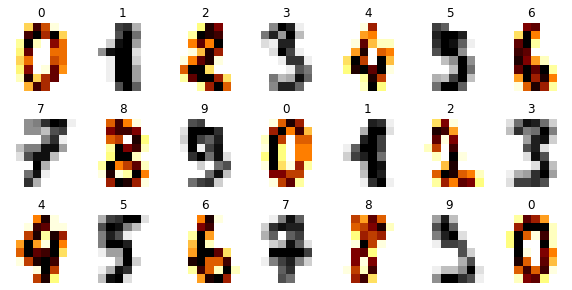

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

[0.6931471805599453]

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

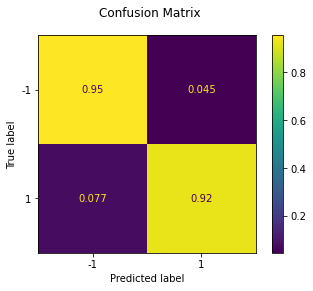

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

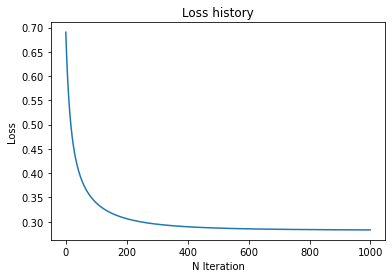

In [17]:
loss_history = model.fit(X_train, y_train)
plt.plot(loss_history)
plt.xlabel("N Iteration")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

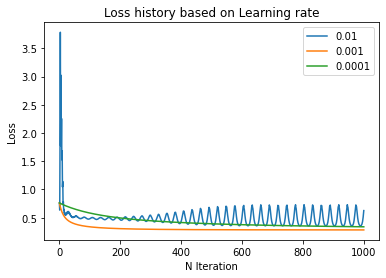

In [18]:
model_1 = CustomLogisticRegression(eta=0.01)
model_2 = CustomLogisticRegression(eta=0.001)
model_3 = CustomLogisticRegression(eta=0.0001)
loss_1 = model_1.fit(X_train, y_train)
loss_2 = model_2.fit(X_train, y_train)
loss_3 = model_3.fit(X_train, y_train)
plt.plot(loss_1)
plt.plot(loss_2)
plt.plot(loss_3)
plt.legend(["0.01","0.001","0.0001"])
plt.xlabel("N Iteration")
plt.ylabel("Loss")
plt.title("Loss history based on Learning rate")
plt.show()

A large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights (we can see "waves" that will lead us to the local minima instead of global one). A learning rate that is too small may never converge.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

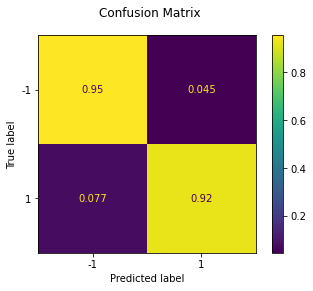

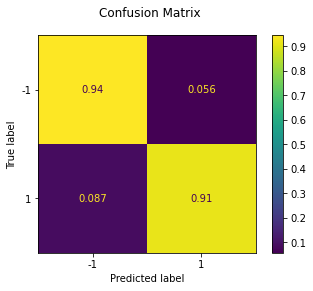

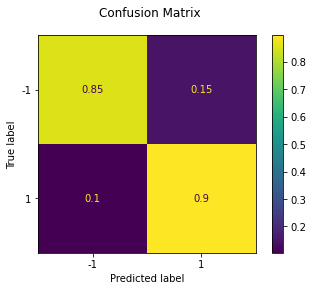

train_acc :  [0.9109255393180237, 0.9039665970772442, 0.8455114822546973]
test_acc :  [0.9388888888888889, 0.9277777777777778, 0.875]


In [19]:
model_1 = CustomLogisticRegression(C=1.0)
model_2 = CustomLogisticRegression(C=0.5)
model_3 = CustomLogisticRegression(C=0.01)
train = []
test = []
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
test.append(test_acc)
train.append(train_acc)
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)
test.append(test_acc)
train.append(train_acc)
train_acc, test_acc = fit_evaluate(model_3, X_train, y_train, X_test, y_test)
test.append(test_acc)
train.append(train_acc)
print("train_acc : ",train)
print("test_acc : ", test)

With the decrease of regularization parameter ( => stronger regularization) our model loses the level of accuracy.

**(0.5 points)** Compare zero initialization and random initialization. 

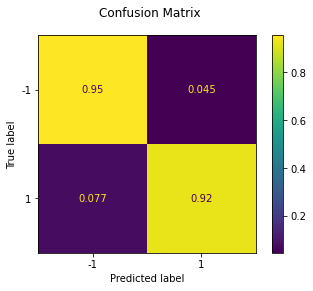

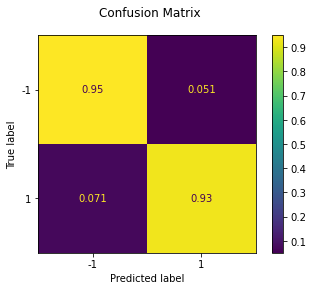

In [20]:
model_1 = CustomLogisticRegression(zero_init=False)
model_2 = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)

If all the weights are initialized with 0, the derivative with respect to loss function is the same for every w, thus all weights have the same value in subsequent iterations. This makes hidden units symmetric and continues for all the n iterations i.e. setting weights to 0 does not make it better than a linear model.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [21]:
import scipy

In [22]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps  
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        
        dist = scipy.spatial.distance_matrix(X, Y)
        return dist
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        weights_all = []
        df_w = pd.DataFrame(weights)
        df_w["metrics"] = y
        att = df_w.groupby("metrics").sum().to_dict()
        for i in self.classes_:
            try: 
                weights_all.append(att[0][i])
            except: weights_all.append(0)
        return weights_all            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            p_small_dist = np.sort(P,axis = 1)[:,:self.n_neighbors]
            y_small_dist = self.y[P.argsort(axis=1)[:,:self.n_neighbors]]
            weights_of_points = np.ones(p_small_dist.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(p_small_dist + self.eps)
            weights_i = []
            for i in range(weights_of_points.shape[0]):
                weights_i.append(self.get_class_weights(y_small_dist[i],weights_of_points[i]))
            y_prob = np.array(weights_i)/np.sum(weights_i,axis=1)[:,None]
            return y_prob        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        pred_prob = self.predict_proba(X)
        prediction = np.argmax(pred_prob,axis = 1)
        return prediction

In [23]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [24]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [25]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

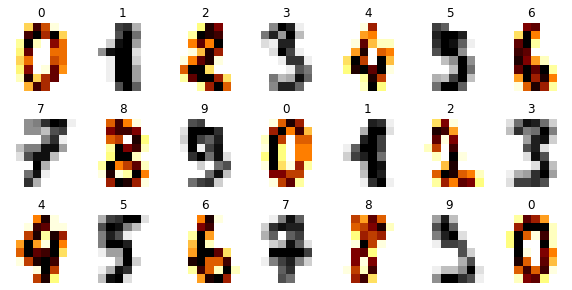

In [26]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [27]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [28]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

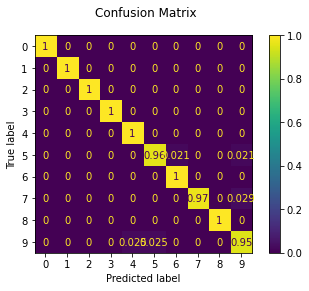

In [29]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [30]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

5, 6 , 9 are very similar in shape so the model confuses these numbers.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

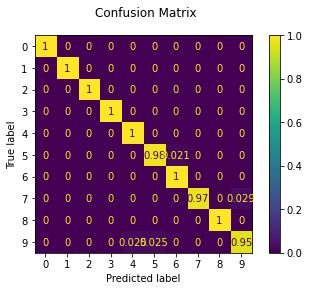

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

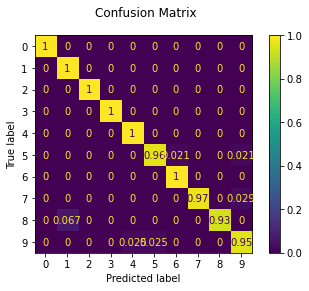

In [32]:
model = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

When we increase n_neigbors up to 7, the model has less confusion about 5. if we increase n_neigbors further (up to 10), the results are getting worse. Hence, error rate initially decreases and reaches a minima. After the minima point, it then increases with increasing n_neigbors.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

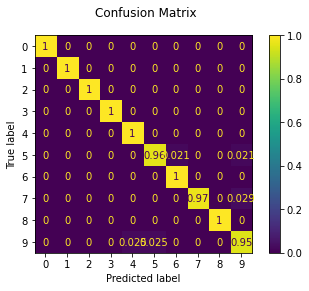

In [33]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

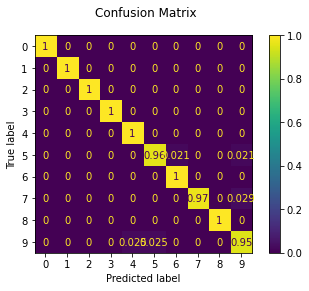

In [34]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

"Uniform" weights means that all neighbors get an equally weighted "vote" about an observation’s class while weights = "distance" would tell the learner to weigh each observation’s "vote" by its distance from the observation we are classifying. 

It is expected that using weights="distance" would tend to overfit more. The reason for this is that it can potentially overly prioritize the closest neighbor and disregard the other nearest neighbors if they are a bit further away. So it might be better to use "distance" when a model is underfitting, which could be characterized by many "average" predictions.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

In [35]:
from sklearn.metrics import f1_score
for metric in ["euclidean","manhattan","chebyshev","hamming","canberra","braycurtis"]:
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance',metric = metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred,average = "micro"))

0.9861111111111112 0.9861111111111112
0.9805555555555555 0.9805555555555555
0.9805555555555555 0.9805555555555555
0.8916666666666667 0.8916666666666667
0.9638888888888889 0.9638888888888889
0.9805555555555555 0.9805555555555555


Looks like Euclidean distance is a better option for our task.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Manhattan Distance – This distance is also known as taxicab distance or city block distance, that is because the way this distance is calculated. The distance between two points is the sum of the absolute differences of their Cartesian coordinates. This distance is preferred over Euclidean distance when we have a case of high dimensionality.

Cosine Distance – This distance metric is used mainly to calculate similarity between two vectors. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in the same direction. It is often used to measure document similarity in text analysis. 

Hamming Distance - Hamming distance is a metric for comparing two binary data strings. While comparing two binary strings of equal length, Hamming distance is the number of bit positions in which the two bits are different. 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [36]:
PATH = "D:\\Python_study\\ML-Intro\\ML-Intro\\04_Classification_Linear_models_and_KNN\\data"

In [37]:
data = pd.read_csv(os.path.join(PATH,'train.csv')).set_index('PassengerId')

In [38]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [40]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [41]:
data.isnull().sum().sort_values(ascending=False)

Cabin       67866
Ticket       4623
Age          3292
Embarked      250
Fare          134
Survived        0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
dtype: int64

In [42]:
null = data.isnull().sum()/len(data)*100
null

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

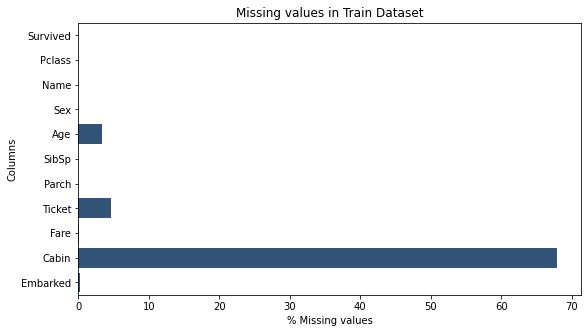

In [43]:
plt.figure(figsize = (9,5))
sns.barplot(x = null.values, y = list(null.index), color='#265484')
plt.xlabel("% Missing values")
plt.ylabel("Columns")
plt.title("Missing values in Train Dataset")
plt.show()

In [44]:
data["Cabin"] = data["Cabin"].fillna(data["Cabin"].mode()[0])
data.isnull().sum().sort_values(ascending=False)

Ticket      4623
Age         3292
Embarked     250
Fare         134
Survived       0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Cabin          0
dtype: int64

In [45]:
data["Ticket"] = data["Ticket"].fillna(data["Ticket"].mode()[0])
data["Embarked"] = data["Embarked"].fillna("S") 
#S - Southampton Port had most passangers and the number of missing values is insignificant

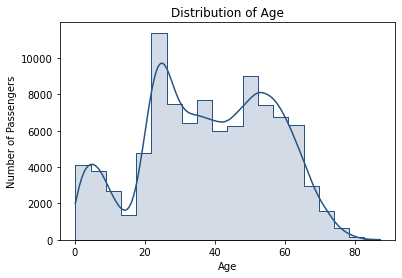

In [46]:
sns.histplot(data = data['Age'],bins=20,kde=True, color='#265484',element="step", alpha=0.2)
plt.title('Distribution of Age')
plt.ylabel('Number of Passengers')
plt.show()

Age distribution is left skewed to some extend so we will use median to fill in the missing values.

In [47]:
median_age = data["Age"].median()
data["Age"] = data["Age"].fillna(median_age)
data.isnull().sum().sort_values(ascending=False)

Fare        134
Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Cabin         0
Embarked      0
dtype: int64

In [48]:
#Fill in missing fare values with mean by class (because fare is dependent on class)
data_mean_fare = lambda x: x.fillna(x.mean())
data["Fare"] = data.groupby(["Pclass"])["Fare"].apply(lambda x: x.fillna(x.mean()))
pcl_fare = data.groupby(["Pclass"])["Fare"].mean()
pcl1_mean_fare = pcl_fare.iloc[0]
pcl2_mean_fare = pcl_fare.iloc[1]
pcl3_mean_fare = pcl_fare.iloc[2]
data.isnull().sum().sort_values(ascending=False)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

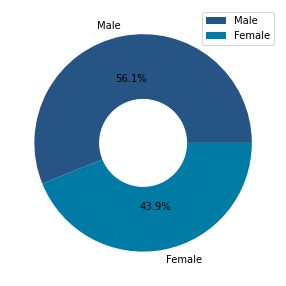

In [49]:
#Passengers by sex
plt.figure(figsize=(9,5))
colors = ["#265484","#007ba6","#00a2af","#00c59f","#8fe383","#f9f871"]
sns.set_palette(sns.color_palette(colors))
d = data["Sex"].value_counts()
plt.pie(d,labels = ["Male","Female"],autopct='%.1f%%',)
circle = plt.Circle( (0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.legend()
plt.show()

Almost 60% of the Titanic passenegers were men.

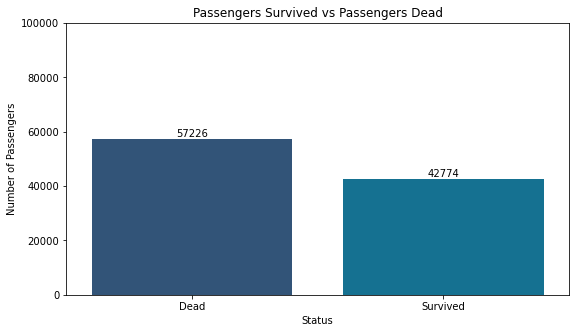

In [50]:
# No of Survived and Dead
plt.figure(figsize=(9,5))
colors = ["#265484","#007ba6","#00a2af","#00c59f","#8fe383","#f9f871"]
sns.set_palette(sns.color_palette(colors))
ax = sns.countplot(x="Survived", data=data)
plt.xlabel("Status")
plt.ylabel("Number of Passengers")
plt.title("Passengers Survived vs Passengers Dead")
plt.ylim(0,100000)
plt.xticks([0,1], ['Dead', 'Survived'])
ax.bar_label(ax.containers[0])
plt.show()

More than 50% of passengers died.

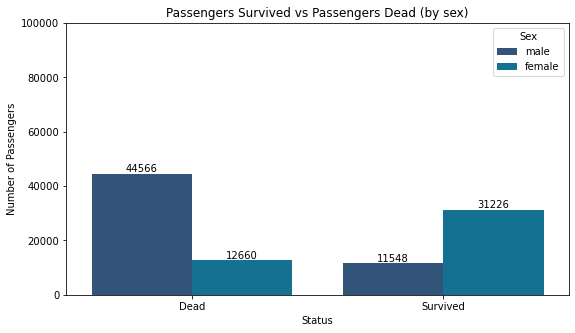

In [51]:
#Survival by sex
plt.figure(figsize=(9,5))
colors = ["#265484","#007ba6","#00a2af","#00c59f","#8fe383","#f9f871"]
sns.set_palette(sns.color_palette(colors))
ax = sns.countplot(x="Survived", hue="Sex", data=data)
plt.xlabel("Status")
plt.ylabel("Number of Passengers")
plt.title("Passengers Survived vs Passengers Dead (by sex)")
plt.ylim(0,100000)
plt.xticks([0,1], ['Dead', 'Survived'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

Although initially there were more male passengers aboard the titanic, more women survived.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

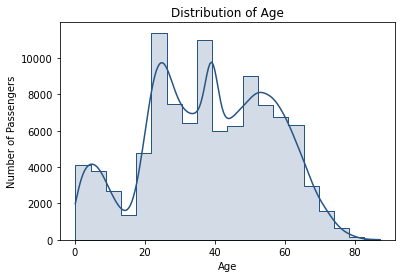

In [52]:
sns.histplot(data = data['Age'],bins=20,kde=True, color='#265484',element="step", alpha=0.2)
plt.title('Distribution of Age')
plt.ylabel('Number of Passengers')
plt.show()

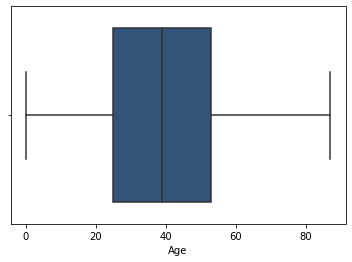

In [53]:
sns.boxplot(x = data['Age'],color='#265484')
plt.show()

Age distribution is left skewed to some extend.

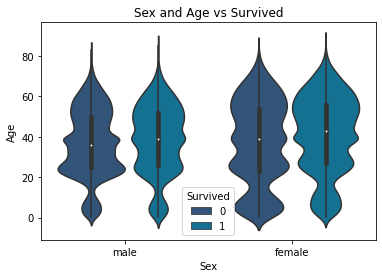

In [54]:
sns.violinplot(x="Sex",y="Age", hue="Survived", data=data)
plt.title("Sex and Age vs Survived")
plt.show()

Survival rate of children under 10 years old is quite good. Survival rate is quite better for women of all ages.

In [55]:
#Mean age of survived and deceased passengers
data[["Survived", "Age"]].groupby("Survived").mean()

,Age
Survived,
0,36.786212
1,40.504542


In [56]:
#Median age of survived and deceased passengers
data[["Survived", "Age"]].groupby("Survived").median()

,Age
Survived,
0,37.0
1,42.0


We can see that mean and median age for survived passengers is ~41. And both median and mean age for deceased passenegers is about 37 years old.

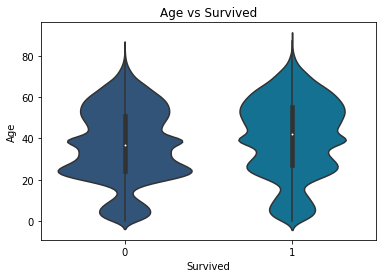

In [57]:
sns.violinplot(x="Survived",y="Age", data=data)
plt.title("Age vs Survived")
plt.show()

Among dead passengers we can see many young people 20-37 years old which is connected to passengers class.

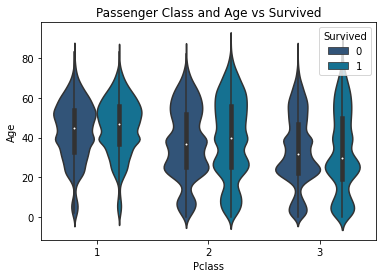

In [58]:
sns.violinplot(x = "Pclass",y="Age",hue="Survived",data=data)
plt.title("Passenger Class and Age vs Survived")
plt.show()

Younger passgengers could not afford expensive 1st class tickets. We can see that number children and young people is increasing from 1st to 3rd classs, with the highest number in 3rd class. 

The first class cabins were almost all in the upper superstructure of the ship. This is also where all of the lifeboats happened to be located. 2and and 3rd class passengers were given a lower priority for the lifeboats.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

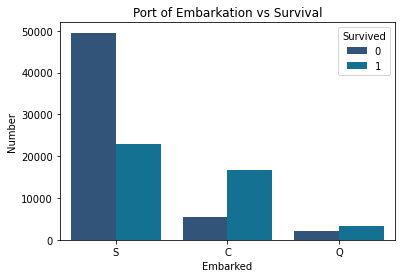

In [59]:
sns.countplot(x=data["Embarked"],hue = data["Survived"],data = data)
plt.ylabel("Number")
plt.title("Port of Embarkation vs Survival")
plt.show()

Passengers who started their journey from Southampton Port mostly died.

In [60]:
embarked_pcl_pivot = data.pivot_table(values=["Survived"], index=["Embarked", "Pclass"])
embarked_pcl_pivot

Survived
Embarked Pclass          
C        1       0.773959
         2       0.815627
         3       0.592646
Q        1       0.627299
         2       0.654028
         3       0.401689
S        1       0.411453
         2       0.437474
         3       0.203562

3rd class passengers from Souththampon Port were the least fortunate to survive. Survival rate for 1st and 2and class from this port are 41% and 44% respectively. The highest survival rates are among passengers from Cherbourg for all 3 classes.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [61]:
#We have already treated missing values before the EDA section
null = data.isnull().sum()/len(data)*100
null

Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

<span style='color:red'> Please check the detailed code before the EDA section.</span>

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

<span style='color:red'> Please check the detailed code before the EDA section.</span>

<span style='color:red'> 1) Cabin column contains almost 68% of null values. We filled in them with Mode. Similarly we treated Ticket column. Embarked column we filled with S - Southampton Port as it had most passangers and the number of missing values was insignificant.</span>

<span style='color:red'> 2) We had a look at Age distribution before deciding how to treat null values as Age was one of the most important attributes of survival. Age distribution was left skewed to some extend so we used median to fill in the missing values.</span>

<span style='color:red'> 3) We filled in missing fare values with mean by class (because fare is dependent on class).</span>

<span style='color:red'> Main disadvantage is that filling in missing points especially with the mean or median can affect all the rest of that information. So the filled-in dataset will be less accurate for drawing conclusions about the actual population.</span>

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [62]:
data_c = data.copy()
# Sex to digits
data_c["Sex"] = data_c["Sex"].map({"male" : 0, "female" : 1}).astype("int64")
  
# Embarked to digits
data_c["Embarked"] = data_c["Embarked"].map({"C" : 0, "Q" : 1, "S" : 2}).astype("int64")

In [63]:
target = "Survived"
other_features = ["Age", "Pclass", "Embarked", "Parch", "SibSp", "Sex","Fare"]

In [64]:
X = data_c[other_features]
y = data_c[target]

In [65]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [68]:
log = LogisticRegression()

In [69]:
log.fit(X_train,y_train)
prediction=log.predict(X_valid)
score=cross_val_score(log,X_train,y_train,cv=5, scoring = "accuracy")
print("Mean Accuracy:",round(np.mean(score),4))

Mean Accuracy: 0.7663


In [70]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [71]:
knn.fit(X_train,y_train)
prediction=knn.predict(X_valid)
score=cross_val_score(knn,X_train,y_train,cv=5, scoring = "accuracy")
print("Mean Accuracy:",round(np.mean(score),4))

Mean Accuracy: 0.7432


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

#### Feature Engineering

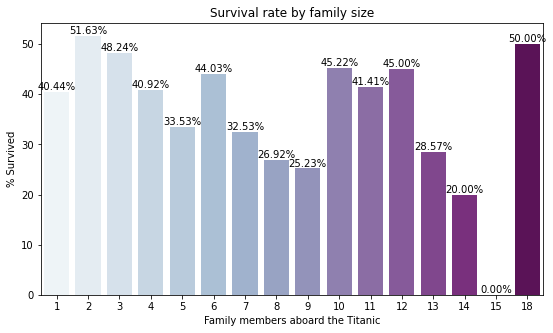

In [72]:
data_c["Family"] = data_c["SibSp"] + data_c["Parch"] + 1
df_5 = data_c.groupby("Family")["Survived"].apply(lambda x: x.sum()/len(x)*100)
plt.figure(figsize=(9,5))
ax = sns.barplot(x = list(df_5.index), y = df_5.values, palette = "BuPu")
plt.xlabel("Family members aboard the Titanic")
plt.ylabel("% Survived")
plt.title("Survival rate by family size")
ax.bar_label(ax.containers[0],fmt='%.2f%%')
plt.show()

Survival rate for small families of 2 was the highest - 51.63%

In [73]:
data_c['Cabin_name'] = [i[0] for i in data_c['Cabin']]
data_c['Cabin_number'] = [i[1:] for i in data_c['Cabin']]
data_c.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Cabin_name,Cabin_number
PassengerId,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",0,39.00,2,0,209245,27.14,C12239,2,3,C,12239
1,0,3,"Bryan, Drew",0,39.00,0,0,27323,13.35,C19828,2,1,C,19828
2,0,3,"Owens, Kenneth",0,0.33,1,2,CA 457703,71.29,C19828,2,4,C,19828
3,0,3,"Kramer, James",0,19.00,0,0,A. 10866,13.04,C19828,2,1,C,19828
4,1,3,"Bond, Michael",0,25.00,0,0,427635,7.76,C19828,2,1,C,19828


In [74]:
print(data_c["Cabin_name"].value_counts())
data_c.drop('Cabin', inplace = True, axis = 1)

C    79691
B     7439
A     6307
D     3637
E     1749
F      663
G      482
T       32
Name: Cabin_name, dtype: int64


In [75]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Survived      100000 non-null  int64  
 1   Pclass        100000 non-null  int64  
 2   Name          100000 non-null  object 
 3   Sex           100000 non-null  int64  
 4   Age           100000 non-null  float64
 5   SibSp         100000 non-null  int64  
 6   Parch         100000 non-null  int64  
 7   Ticket        100000 non-null  object 
 8   Fare          100000 non-null  float64
 9   Embarked      100000 non-null  int64  
 10  Family        100000 non-null  int64  
 11  Cabin_name    100000 non-null  object 
 12  Cabin_number  100000 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 12.7+ MB


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [77]:
#la = LabelEncoder()
#for i in data_c.columns:
 #   if data_c[i].dtype == 'object':
  #      data_c[i] = la.fit_transform(data_c[i])
#data_c.info()

In [78]:
data_c.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.427740,2.106910,0.43886,38.376690,0.397690,0.454560,43.929065,1.502020,1.852250
std,0.494753,0.837727,0.49625,18.009956,0.862566,0.950076,69.552036,0.832912,1.412792
min,0.000000,1.000000,0.00000,0.080000,0.000000,0.000000,0.680000,0.000000,1.000000
25%,0.000000,1.000000,0.00000,25.000000,0.000000,0.000000,10.040000,1.000000,1.000000
50%,0.000000,2.000000,0.00000,39.000000,0.000000,0.000000,24.470000,2.000000,1.000000
75%,1.000000,3.000000,1.00000,53.000000,1.000000,1.000000,33.500000,2.000000,2.000000
max,1.000000,3.000000,1.00000,87.000000,8.000000,9.000000,744.660000,2.000000,18.000000


In [79]:
CabinType_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
                 'F': 5, 'G': 6, 'T': 7}
data_c['Cabin_type'] = data_c['Cabin_name'].map(CabinType_map).astype('int')
data_c.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Cabin_name,Cabin_number,Cabin_type
PassengerId,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",0,39.00,2,0,209245,27.14,2,3,C,12239,2
1,0,3,"Bryan, Drew",0,39.00,0,0,27323,13.35,2,1,C,19828,2
2,0,3,"Owens, Kenneth",0,0.33,1,2,CA 457703,71.29,2,4,C,19828,2
3,0,3,"Kramer, James",0,19.00,0,0,A. 10866,13.04,2,1,C,19828,2
4,1,3,"Bond, Michael",0,25.00,0,0,427635,7.76,2,1,C,19828,2


In [80]:
target = "Survived"
other_features = ["Age", "Pclass", "Embarked", "Parch", "SibSp", "Sex","Fare","Family"]

In [81]:
X = data_c[other_features]
y = data_c[target]

In [82]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y,)

In [84]:
param_grid = {'n_neighbors': np.arange(1, 25)}

In [85]:
knn_cv = GridSearchCV(knn, param_grid, cv=5,scoring = "accuracy")

In [86]:
knn_cv.fit(X, y)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 23}
0.7662699999999999


In [88]:
knn_best = KNeighborsClassifier(n_neighbors=23)
knn_best.fit(X_train,y_train)
y_pred = knn_best.predict(X_valid)
score = cross_val_score(knn,X_train,y_train,cv=5, scoring = "accuracy")
print("Mean Accuracy:",round(np.mean(score),4))

Mean Accuracy: 0.7412


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.